##  Post processing jupyter notebook tutorial  for microstate file in MCCE. 

# MS analysis 
### tutorial https://github.com/umeshkhaniya/ms_tutorial/blob/main/microstate_analysis.ipynb
### YOU WILL NEED SUBRUOTINES (from git_hub repository) ms_analysis.py and weighted_correlation.py 

### IN MCCE run.prm set: t    (MS_OUT)
### IN MCCE suggest you run only one pH (set initial pH ((TITR_PH0)) to desired pH; and (TITR_STEPS) to 1 )
### MCCE outputs needed:   head3.lst and a text file from ms_out folder e.g. ms_out/pH7eH0ms.txt  
### You will need to define the input file as mc = msa.MSout("pH7eH0ms.txt"); head3.lst must be in this directory with this hame


### Load the Library to read the input files. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
%matplotlib inline

## This is the script you need to read the microstate file.

In [2]:
import ms_analysis as msa 

### Input file is  pH7eH0ms.txt obtained from MCCE output.  File pH7eH0ms.txt means system run at pH at 7 and eH  0.

In [3]:
mc = msa.MSout("ms_out/pH7eH0ms.txt")

### This will save microstate energy, count and microstate id. These quantities are saved in a list and list are sorted based enthalpy from lowest to highest 

In [4]:
ms_orig_lst = [[ms.E, ms.count, ms.state] for  ms in list((mc.microstates.values()))]
ms_orig_lst = sorted(ms_orig_lst, key = lambda x:x[0])
print(ms_orig_lst[:5])

[[-178.660278, 6, [0, 7, 36, 43, 46, 55, 58, 72, 76, 78, 81, 83, 86, 92, 95, 104, 112, 116, 129, 132, 137, 146, 162, 174, 185, 188, 198, 203, 211, 223, 228, 229, 233, 236, 245, 253, 254, 263]], [-178.638748, 1, [0, 7, 36, 43, 46, 55, 58, 72, 76, 78, 81, 83, 86, 92, 94, 104, 112, 116, 129, 132, 137, 146, 162, 174, 184, 188, 198, 203, 211, 223, 228, 229, 233, 236, 245, 253, 254, 263]], [-178.630325, 3, [0, 7, 36, 43, 46, 55, 58, 72, 76, 78, 81, 83, 86, 92, 94, 104, 112, 116, 129, 132, 137, 146, 160, 174, 185, 188, 197, 203, 211, 223, 228, 229, 233, 236, 245, 253, 254, 263]], [-178.629166, 2, [0, 7, 36, 43, 46, 55, 58, 72, 76, 78, 81, 83, 86, 92, 94, 104, 112, 116, 129, 132, 137, 146, 160, 174, 185, 188, 198, 203, 211, 223, 228, 229, 233, 237, 245, 253, 254, 263]], [-178.608368, 8, [0, 6, 36, 43, 46, 55, 58, 72, 76, 78, 81, 83, 86, 92, 94, 104, 112, 116, 129, 132, 137, 146, 162, 174, 185, 188, 198, 203, 211, 223, 228, 229, 233, 236, 245, 253, 254, 263]]]


### Total number of ms steps (N_ms) and total unique conformer ms (N_uniq).

In [5]:
print(mc.N_ms)
print(mc.N_uniq)

1200000
447522


In [6]:
# This will flattened the list based on the count
energy_lst_count =np.asarray([a for a,f in zip([x[0] for x in ms_orig_lst], [x[1] for x in ms_orig_lst]) for _ in range(f)])


## This is to fit the equation using the skewed normal ditribution and plot the equation.

In [7]:
from scipy.stats import norm, skewnorm
(mu, sigma) = norm.fit(energy_lst_count)
skewness, mean, std = skewnorm.fit(energy_lst_count)

print(mu, sigma)
print(skewness, mean, std)

-174.49745041346907 1.6747856213046677
2.857179297479374 -176.40940217209499 2.54174586045566


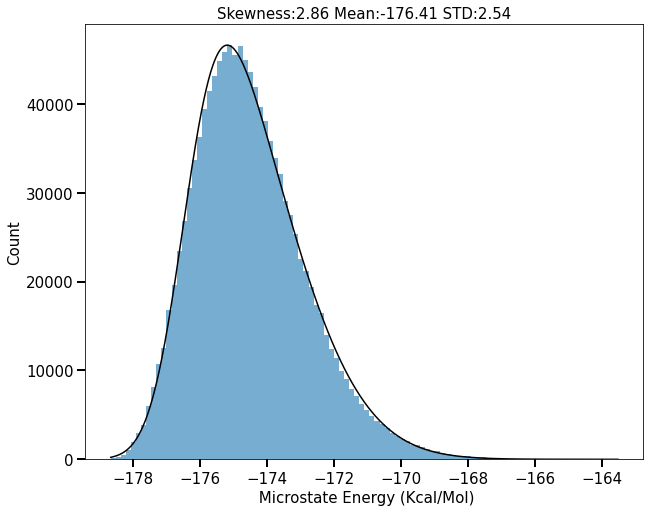

In [8]:
# plot the figure
fig = plt.figure(figsize = (10,8))
graph_hist = plt.hist(energy_lst_count,bins=100, alpha=0.6)
Y = graph_hist[0]
y = skewnorm.pdf(np.array(energy_lst_count), skewness, mean, std)
pdf_data = Y.max()/max(y)*y
plt.plot(energy_lst_count,pdf_data , label = 'approximated skewnorm', color = 'black')
plt.title("Skewness:"+str(round(skewness,2))+ " " + "Mean:"+str(round(mean,2))+ " " + "STD:"+str(round(std,2)), fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel(" Microstate Energy (Kcal/Mol)", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.tick_params(axis="x", direction="out", length=8, width=2)
plt.tick_params(axis="y", direction="out", length=8, width=2)
fig.savefig("enthalpy_dis.pdf", dpi = 600, bbox_inches = "tight");

### In MCCE, there are group of  free and fixed residues. Free residues appear in the microstate id list but fixed residues not. Fixed residues can have the titrating residues so it is important to look up the fixed residues and their contributing total charge is called here as background charge. 

#### Free residues information

In [9]:
free_residues = []
for res in mc.free_residues:
    free_residues.append(msa.conformers[res[0]].resid)
ms_free_residues = pd.DataFrame(free_residues,columns = ["Residue"])
ms_free_residues[:5]

,Residue
0,NTRA0001_
1,LYSA0001_
2,HISA0015_
3,ASNA0019_
4,TYRA0020_


### Fixed residues charge. Make sure look fixed residues charge for MD protonation input.

In [10]:
# this is to write the fixed charge state
fixed_res_crg_dict = {}
for conf in msa.conformers:
    if conf.iconf in mc.fixed_iconfs:
        try: 
            if conf.resid not in fixed_res_crg_dict:
                fixed_res_crg_dict[conf.resid] = conf.crg
        except:
            print("Error in ms file!Fixed residues are duplicating")

background_charge = sum(fixed_res_crg_dict.values())
print(background_charge)

9.0


In [11]:
print(fixed_res_crg_dict)

{'VALA0002_': 0.0, 'PHEA0003_': 0.0, 'ARGA0005_': 1.0, 'CYDA0006_': 0.0, 'GLUA0007_': -1.0, 'LEUA0008_': 0.0, 'ALAA0009_': 0.0, 'ALAA0010_': 0.0, 'ALAA0011_': 0.0, 'META0012_': 0.0, 'LYSA0013_': 1.0, 'ARGA0014_': 1.0, 'LEUA0017_': 0.0, 'ASPA0018_': -1.0, 'ARGA0021_': 1.0, 'TYRA0023_': 0.0, 'LEUA0025_': 0.0, 'TRPA0028_': 0.0, 'VALA0029_': 0.0, 'CYDA0030_': 0.0, 'ALAA0031_': 0.0, 'ALAA0032_': 0.0, 'LYSA0033_': 1.0, 'PHEA0034_': 0.0, 'SERA0036_': 0.0, 'ASNA0037_': 0.0, 'PHEA0038_': 0.0, 'ALAA0042_': 0.0, 'ARGA0045_': 1.0, 'ASPA0052_': -1.0, 'TYRA0053_': 0.0, 'ILEA0055_': 0.0, 'LEUA0056_': 0.0, 'ILEA0058_': 0.0, 'ARGA0061_': 1.0, 'TRPA0062_': 0.0, 'TRPA0063_': 0.0, 'CYDA0064_': 0.0, 'ASPA0066_': -1.0, 'ARGA0068_': 1.0, 'PROA0070_': 0.0, 'SERA0072_': 0.0, 'ARGA0073_': 1.0, 'ASNA0074_': 0.0, 'LEUA0075_': 0.0, 'CYDA0076_': 0.0, 'ILEA0078_': 0.0, 'PROA0079_': 0.0, 'CYDA0080_': 0.0, 'SERA0081_': 0.0, 'ALAA0082_': 0.0, 'LEUA0083_': 0.0, 'LEUA0084_': 0.0, 'ILEA0088_': 0.0, 'ALAA0090_': 0.0, 'SERA

### This will keep only our interested fixed residues and their charge information. 


# Note: Make sure to add your all interested residues name here (such as quinone)

In [12]:
your_interested_res = ["ASP", "GLU", "ARG", "HIS", "LYS", "CYS", "TYR", "NTR", "CTR"]

### Keep only your interested residue information in fixed residues

In [13]:
fixed_interested_res = {i:j for i,j in fixed_res_crg_dict.items() if i[:3] in your_interested_res}
fixed_residues_crg = pd.DataFrame(fixed_interested_res.items(), columns=['Residue', 'crg'])
fixed_residues_crg.head() 

,Residue,crg
0,ARGA0005_,1.0
1,GLUA0007_,-1.0
2,LYSA0013_,1.0
3,ARGA0014_,1.0
4,ASPA0018_,-1.0


In [14]:
print(len(fixed_interested_res))

23


### This will convert the microstate conformer id to corresponding charge.

In [15]:
id_vs_charge = {}
for conf in msa.conformers:
    id_vs_charge[conf.iconf] = conf.crg

def convert_ms_crg(l, d):
    crg_lst =[[y[0], y[1], [convert_ms_crg(x, d) if isinstance(x, list) else d.get(x, x) for x in y[2]]] for y in l]
    return crg_lst

crg_orig_lst = convert_ms_crg(ms_orig_lst, id_vs_charge )
print(crg_orig_lst[:5])

[[-178.660278, 6, [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]], [-178.638748, 1, [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]], [-178.630325, 3, [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]], [-178.629166, 2, [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]], [-178.608368, 8, [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

## This will give the unique charge state id, corresponding count.

In [16]:
import sys
def findUniqueCrgmsCountOrder(crg_list_ms, begin_energy = None, end_energy = None):
    """You need to supply the charge list microstate here. Make sure
    the crg file is sorted with increasing order.If you want to filter 
    charge id based on the energy. Then you need to supply here.
    unique_crg_state_order gives the order of unique charge state based on energy. 
    Lowest energy charge state will give the order 1 and then second unique charge 
    state will give the order 2. This order is based on unique charge ms order.
    """
    if not begin_energy and not end_energy:
        print("All energy microstates are selected.")
        begin_energy = crg_list_ms[0][0]
        end_energy = crg_list_ms[-1][0]
    elif begin_energy and end_energy:
        crg_list_ms = [[x[0], x[1], x[2]] for x in crg_list_ms if x[0] >= begin_energy and x[0] <= end_energy]   
    else:
        sys.exit('Give the lower or upper energy bound.')
        
    #unique charge as key and energy, count and order
    crg_all_count = {}
    unique_crg_state_order = 1
    for x, array in enumerate(crg_list_ms):
        if tuple(array[2]) not in crg_all_count.keys():
            crg_all_count[(tuple(array[2]))] = [array[1], [array[0]], [unique_crg_state_order]]
            unique_crg_state_order +=1
        else:
            crg_all_count[(tuple(array[2]))][0] += array[1]
            # add the maximum and minimum energy 
            min_energy = min(min(crg_all_count[(tuple(array[2]))][1]),array[0]) 
            max_energy = max(max(crg_all_count[(tuple(array[2]))][1]),array[0])
            # clear energy list and append minimum and maximum energy
            crg_all_count[(tuple(array[2]))][1].clear()
            crg_all_count[(tuple(array[2]))][1].append(min_energy)
            crg_all_count[(tuple(array[2]))][1].append(max_energy)

    # make a list of count, unique charge microstate, energy difference and order.
    all_crg_ms_unique  = []
    all_count = []
    energy_diff_all = []
    unique_crg_state_order = []
    for u,v in crg_all_count.items():
        all_crg_ms_unique.append(list(u))
        all_count.append(v[0])
        unique_crg_state_order.append(v[2][0])
        if len(v[1]) == 2:
            energy_diff_all.append(round(v[1][1]-v[1][0], 6))
        elif len(v[1]) == 1:
            energy_diff_all.append(0)
        else:
            sys.exit("There is error while creating unique charge state.")
    print(f"Total number of state: {len(crg_list_ms)}")
    print(f"Total number of  Unique charge ms: {len(all_crg_ms_unique)}")
    return all_crg_ms_unique, all_count, unique_crg_state_order, energy_diff_all 


In [17]:
def ConcaCrgMsPandas(unique_crg_ms_list, ms_count, ms_order, free_residues, background_charge, residue_interest_list):
    unique_crg_ms_list_pd = pd.DataFrame(unique_crg_ms_list).T
    ms_count_pd = pd.DataFrame(ms_count,columns = ["Count"]).T
    ms_order_pd = pd.DataFrame(ms_order,columns = ["Order"]).T
    crg_ms_count_pd = pd.concat([unique_crg_ms_list_pd, ms_count_pd, ms_order_pd])
    crg_count_res_1 = pd.concat([free_residues,crg_ms_count_pd], axis=1)
    crg_count_res_1.loc["Count", 'Residue'] = 'Count'
    crg_count_res_1.loc["Order", 'Residue'] = 'Order'
    all_crg_count_res = crg_count_res_1.set_index("Residue")
    # sort based on the count
    all_crg_count_res = all_crg_count_res.sort_values(by = "Count", axis = 1, ascending = False)
    all_crg_count_res.columns = range(all_crg_count_res.shape[1])
    all_crg_count_res = all_crg_count_res.T.set_index("Order")
    all_crg_count_res["Occupancy"] = round(all_crg_count_res["Count"]/ sum(all_crg_count_res["Count"]),3)
    all_crg_count_res['Sum_crg_protein'] =  all_crg_count_res.iloc[:, :-2].sum(axis = 1) + background_charge
    crg_count_res = all_crg_count_res.copy()
    for i in all_crg_count_res.columns:
        if i[:3] not in residue_interest_list and i != "Occupancy" and i != "Count" and i != "Sum_crg_protein":
            crg_count_res.drop([i], axis = 1, inplace = True)

    return crg_count_res

## Select all energy microstate list

In [18]:
charge_ms_file = findUniqueCrgmsCountOrder(crg_orig_lst)
all_crg_count_res = ConcaCrgMsPandas(charge_ms_file[0], charge_ms_file[1], charge_ms_file[2], 
                                     ms_free_residues, background_charge,your_interested_res )


All energy microstates are selected.
Total number of state: 447522
Total number of  Unique charge ms: 24


In [19]:
all_crg_count_res.head(4) 

Residue,NTRA0001_,LYSA0001_,HISA0015_,TYRA0020_,GLUA0035_,ASPA0048_,ASPA0087_,ASPA0101_,LYSA0116_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,
1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,571852.0,0.477,8.0
2.0,0.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,387654.0,0.323,7.0
3.0,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,120227.0,0.100,9.0
4.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,92767.0,0.077,8.0


### This will plot the  tautomer charge distribution of unqiue charge microstate based on the occupancy. Each dot are unique charge microstate and color coded based on the energy difference of that microstate appear in Monte Carlo run. Total charge is sum of background and free charge (protein charge).

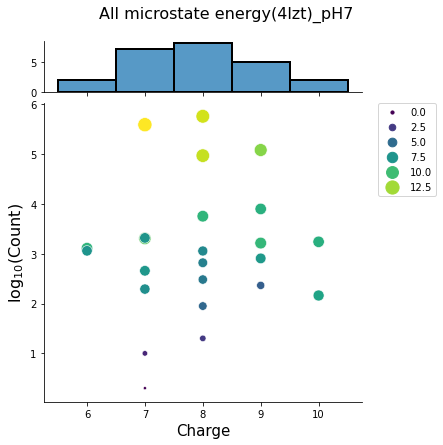

In [20]:
#which tautomer charge state is most populated. This includes the background charge also.
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline
x_av = [sum(x) + background_charge for x in charge_ms_file[0]]
y_av = [math.log10(x) for x in charge_ms_file[1]]
energy_diff_all_fl = [float(x) for x in charge_ms_file[3]]
g1 = sns.JointGrid(marginal_ticks=True, height = 6)
ax = sns.scatterplot(x=x_av, y=y_av, hue = energy_diff_all_fl, palette = 'viridis', size = energy_diff_all_fl, sizes=(10, 200), ax=g1.ax_joint)
ax.set_xticks(range(int(min(x_av)), int(max(x_av)) + 1))
ax.set_xlabel("Charge",fontsize=15)
ax.set_ylabel("log$_{10}$(Count)",fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2 = sns.histplot(x=x_av, linewidth=2,discrete=True, ax=g1.ax_marg_x)

ax2.set_ylabel(None,fontsize=16)
g1.ax_marg_y.set_axis_off()
g1.fig.subplots_adjust(top= 0.9)
g1.fig.suptitle('All microstate energy(4lzt)_pH7', fontsize = 16)
g1.savefig("all_en_cr_ph7_vs_log(count).pdf", dpi = 600, bbox_inches = "tight");

### This is to get the unique charge microstate less or equal to  lowest energy + 1.36 KCal/Mol. Make sure your supply list is sorted based on energy in ascending order. The order shows in dataframe is here within the selected energy range.

In [21]:
lowest_charge_ms_file = findUniqueCrgmsCountOrder(crg_orig_lst, begin_energy = crg_orig_lst[0][0] , end_energy = crg_orig_lst[0][0] + 1.36)
low_crg_count_res = ConcaCrgMsPandas(lowest_charge_ms_file[0], lowest_charge_ms_file[1], lowest_charge_ms_file[2], 
                                     ms_free_residues, background_charge, your_interested_res )
low_crg_count_res.head() 

Total number of state: 7106
Total number of  Unique charge ms: 4


Residue,NTRA0001_,LYSA0001_,HISA0015_,TYRA0020_,GLUA0035_,ASPA0048_,ASPA0087_,ASPA0101_,LYSA0116_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,
1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,16037.0,0.645,8.0
2.0,0.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,7648.0,0.308,7.0
3.0,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,712.0,0.029,9.0
4.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,469.0,0.019,8.0


### This is to get the unique charge microstate around +/- 0.5 pH unit ( +/- 0.68  Kcal/Mol) of average microstate energy. The order shows in dataframe is here within the selected energy range.

In [22]:
average_charge_ms_file = findUniqueCrgmsCountOrder(crg_orig_lst, begin_energy = (mc.average_E  - 0.68) , end_energy = (mc.average_E  + 0.68))
av_crg_count_res = ConcaCrgMsPandas(average_charge_ms_file[0], average_charge_ms_file[1], average_charge_ms_file[2], 
                                     ms_free_residues, background_charge, your_interested_res )
av_crg_count_res.head() 

Total number of state: 143853
Total number of  Unique charge ms: 16


Residue,NTRA0001_,LYSA0001_,HISA0015_,TYRA0020_,GLUA0035_,ASPA0048_,ASPA0087_,ASPA0101_,LYSA0116_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,
3.0,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,182565.0,0.478,8.0
1.0,0.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,123772.0,0.324,7.0
2.0,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,42249.0,0.111,9.0
4.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,31311.0,0.082,8.0
5.0,0.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,831.0,0.002,9.0


### This is to get the unique charge microstate  of 1KT unit(1.36 Kcal/Mol) less or equal than highest energy state. The order shows in dataframe is here within the selected energy range.

In [23]:
highest_charge_ms_file = findUniqueCrgmsCountOrder(crg_orig_lst, begin_energy = (mc.highest_E  - 1.36) , end_energy = mc.highest_E)
high_crg_count_res = ConcaCrgMsPandas(highest_charge_ms_file[0], highest_charge_ms_file[1], highest_charge_ms_file[2], 
                                     ms_free_residues, background_charge, your_interested_res )
high_crg_count_res.head()

Total number of state: 16
Total number of  Unique charge ms: 4


Residue,NTRA0001_,LYSA0001_,HISA0015_,TYRA0020_,GLUA0035_,ASPA0048_,ASPA0087_,ASPA0101_,LYSA0116_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,
2.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,23.0,0.676,7.0
3.0,0.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,5.0,0.147,7.0
1.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,3.0,0.088,8.0
4.0,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,0.0,1.0,3.0,0.088,10.0


### Save all the pandas data frame.

In [24]:
# save all three data frames and non titrable residues charge information.
writer = pd.ExcelWriter('charge_ms_4lzt_pH7.xlsx', engine='xlsxwriter')
low_crg_count_res.to_excel(writer, sheet_name='low_crg_count_res')
av_crg_count_res.to_excel(writer, sheet_name='av_crg_count_res')
high_crg_count_res.to_excel(writer, sheet_name='high_crg_count_res')
fixed_residues_crg.to_excel(writer, sheet_name = 'fixed_residues_crg')
writer.save()
# Due to coulmn size issue in excel for large sytem. We save in csv format for all charge.                           
all_crg_count_res.to_csv('all_crg_count_res.csv', header = True)

# This is for the post processing of already saved file. This is for to get the correlation matrix for residues. 

In [25]:
# This is for correlation.
all_crg_count_read= pd.read_csv("all_crg_count_res.csv", index_col = 0)
all_crg_count =  all_crg_count_read.iloc[:,:-2]
all_crg_count = all_crg_count.T
all_crg_count

Order,1.0,2.0,3.0,4.0,7.0,6.0,13.0,12.0,8.0,5.0,...,19.0,10.0,17.0,20.0,16.0,18.0,21.0,22.0,23.0,24.0
NTRA0001_,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
LYSA0001_,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
HISA0015_,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
TYRA0020_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLUA0035_,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0
ASPA0048_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ASPA0087_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ASPA0101_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0
LYSA0116_,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
Count,571852.0,387654.0,120227.0,92767.0,7910.0,5654.0,2073.0,2024.0,1732.0,1634.0,...,658.0,454.0,303.0,231.0,195.0,145.0,89.0,20.0,10.0,2.0


In [26]:
# drop if the protonation is not changing in free residues
all_crg_count["std"] = all_crg_count.std(axis = 1).round(3)
all_crg_count_std = all_crg_count.loc[all_crg_count['std'] != 0].T[:-1].reset_index(drop = True)
all_crg_count_std

,NTRA0001_,LYSA0001_,HISA0015_,GLUA0035_,ASPA0101_,LYSA0116_,Count
0,0.0,1.0,1.0,-1.0,-1.0,1.0,571852.0
1,0.0,1.0,0.0,-1.0,-1.0,1.0,387654.0
2,1.0,1.0,1.0,-1.0,-1.0,1.0,120227.0
3,1.0,1.0,0.0,-1.0,-1.0,1.0,92767.0
4,0.0,1.0,1.0,0.0,-1.0,1.0,7910.0
5,0.0,1.0,0.0,0.0,-1.0,1.0,5654.0
6,0.0,1.0,1.0,-1.0,-1.0,0.0,2073.0
7,0.0,0.0,1.0,-1.0,-1.0,1.0,2024.0
8,1.0,1.0,1.0,0.0,-1.0,1.0,1732.0
9,1.0,1.0,0.0,0.0,-1.0,1.0,1634.0


In [27]:
#rename the residues with shorter name and 
# keep acid first, then polar, base residues and then MQ in column
def renameOrderResidues(file_input):
    rename_dict = {}
    acid_list = []
    base_list = []
    polar_rest_list = []
    ub_q_list = []
    non_residue_list = []

    for i in file_input.columns[:-1]:
        rename_dict[i] = i[3] + str("_")+ i[:3] + str(int(i[4:8]))
    rename_dict["Count"] = 'Count'
        
    for x, y in rename_dict.items():
        if y[2:5] == 'ASP':
            rename_dict[x] = y[:1]  +'D' + y[5:]
            acid_list.append(y[:1]  +'D' + y[5:])
        if y[2:5] == 'GLU':
            rename_dict[x] = y[:1] +'E' + y[5:]
            acid_list.append(y[:1]  +'E' + y[5:])
        if y[2:5] == 'ARG':
            rename_dict[x] = y[:1] + 'R' + y[5:]
            base_list.append(y[:1]  +'R' + y[5:])
        if y[2:5] == 'HIS':
            rename_dict[x] = y[:1] +'H' + y[5:]
            base_list.append(y[:1] +'H' + y[5:])
        if y[2:5] == 'LYS':
            rename_dict[x] = y[:1]+ 'K' + y[5:]
            base_list.append(y[:1]+ 'K' + y[5:])
        if y[2:5] == 'TYR':
            rename_dict[x] = y[:1] + 'Y' + y[5:]
            polar_rest_list.append(y[:1]+ 'Y' + y[5:])
        if y[2:5] == 'CYS':
            rename_dict[x] = y[:1] + 'C' + y[5:]
            polar_rest_list.append(y[:1]+ 'C' + y[5:])
        if y[2:5] == 'UbQ':
            rename_dict[x] ='UQ' + y[5:]
            ub_q_list.append('UQ' + y[5:])
        if y == 'Count':
            non_residue_list.append(y)
          
    col_order_list = acid_list + polar_rest_list+ base_list + ub_q_list+ non_residue_list
    file_input = file_input.rename(rename_dict, axis =1)
    file_input = file_input[col_order_list]
    return file_input



In [28]:
df = renameOrderResidues(all_crg_count_std)
df

,AE35,AD101,AK1,AH15,AK116,Count
0,-1.0,-1.0,1.0,1.0,1.0,571852.0
1,-1.0,-1.0,1.0,0.0,1.0,387654.0
2,-1.0,-1.0,1.0,1.0,1.0,120227.0
3,-1.0,-1.0,1.0,0.0,1.0,92767.0
4,0.0,-1.0,1.0,1.0,1.0,7910.0
5,0.0,-1.0,1.0,0.0,1.0,5654.0
6,-1.0,-1.0,1.0,1.0,0.0,2073.0
7,-1.0,-1.0,0.0,1.0,1.0,2024.0
8,0.0,-1.0,1.0,1.0,1.0,1732.0
9,0.0,-1.0,1.0,0.0,1.0,1634.0


In [29]:
# drop the residues if any of the correlation value is not greater than 0.1 except that residues.
def dropCorrCriterion(data_frame, cutoff = None):
    if not cutoff:
        cutoff = 0.0   # define the cutoff here
    for i in data_frame.columns:
        if list(abs(data_frame[i]) >= cutoff).count(True) == 1:
            data_frame.drop(i, inplace = True)
            data_frame.drop(i, axis =1, inplace = True)
    return data_frame

In [30]:
#importing the weighted correlation script and obatain the weighted correlation score value.
import weighted_correlation as wc
def heatmapplot(df_heatmap):
    df_correlation_cls= wc.WeightedCorr(df=df_heatmap, wcol='Count')(method='pearson')
    df_heatmap_plot_cls = dropCorrCriterion(df_correlation_cls).round(2)
    return df_heatmap_plot_cls

In [31]:
import weighted_correlation as wc
df_correlation= heatmapplot(df)
df_correlation

,AE35,AD101,AK1,AH15,AK116
AE35,1.00,-0.00,0.01,-0.00,-0.01
AD101,-0.00,1.00,0.00,-0.01,0.00
AK1,0.01,0.00,1.00,-0.01,-0.00
AH15,-0.00,-0.01,-0.01,1.00,-0.00
AK116,-0.01,0.00,-0.00,-0.00,1.00


# With weighted correlation, we don't see the correlation. 

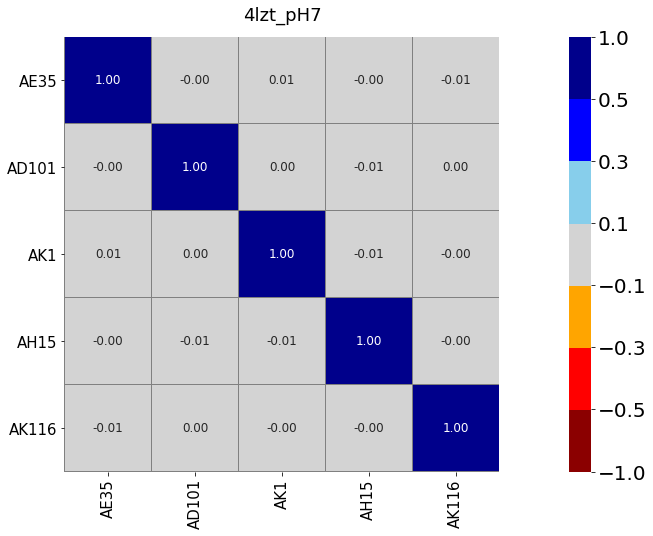

In [32]:
# plot the heatmap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap,ListedColormap,BoundaryNorm
plt.figure(figsize=(25, 8))
cmap = ListedColormap(["darkred", "red", "orange", "lightgray","skyblue", "blue", 'darkblue'])
bounds= [-1.0, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 1.0]
norm =BoundaryNorm(bounds, cmap.N)
heatmap = sns.heatmap(df_correlation, annot=True, linecolor= "gray", cmap=cmap, norm = norm, square = True, fmt=".2f",linewidths=.01,annot_kws={"fontsize":12})#cbar_kws= {"orientation": "horizontal", "shrink": 1})
heatmap.set_title('4lzt_pH7', fontdict={'fontsize':18}, pad=16)
plt.ylabel(None)
plt.xlabel(None)
plt.yticks(fontsize = 15, rotation = 0)
plt.xticks(fontsize = 15, rotation = 90)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.savefig("corr.pdf", dpi = 600, bbox_inches = 'tight');